# Proyek Klasifikasi Gambar: vegetable Image Classification

- **Nama:** Rahadian Muhammad Sutandar
- **Email:** rahadiansutandar@gmail.com
- **ID Dicoding:** rahadian_ms

## Import Semua Packages/Library yang Digunakan

In [3]:
import pandas as pd
import math
from pandas import DataFrame
from google.colab import files
from sklearn.metrics import classification_report

# Library to extract files
import os
import zipfile
import kagglehub

# Import PIL for image processing
from PIL import Image

# Library to display images
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Library to using Image Generator
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

## Data Preparation

In [2]:
#import the dataset we want to use for our project
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0
 97% 518M/534M [00:04<00:00, 151MB/s]
100% 534M/534M [00:04<00:00, 134MB/s]


### Data Loading

In [3]:
local_zip = '/content/vegetable-image-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

#### Split Dataset

 Sebaran Data Sebelum Augmentasi:


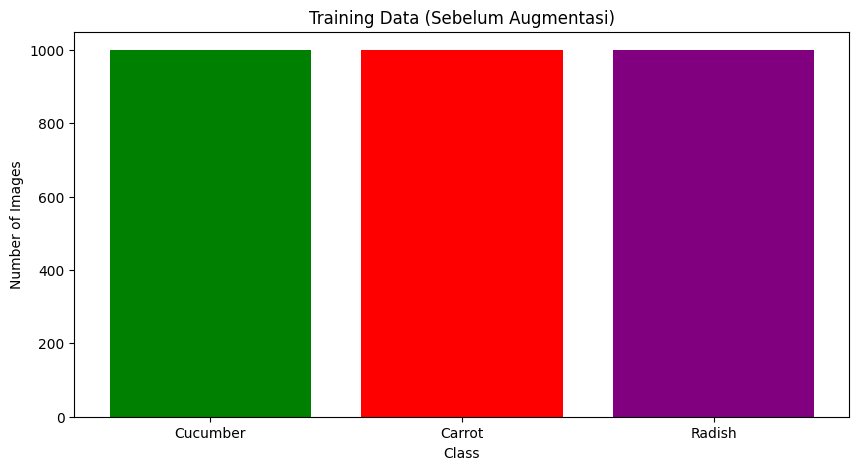


Training Data (Sebelum Augmentasi) Image Counts per Class:
Cucumber: 1000 images
Carrot: 1000 images
Radish: 1000 images


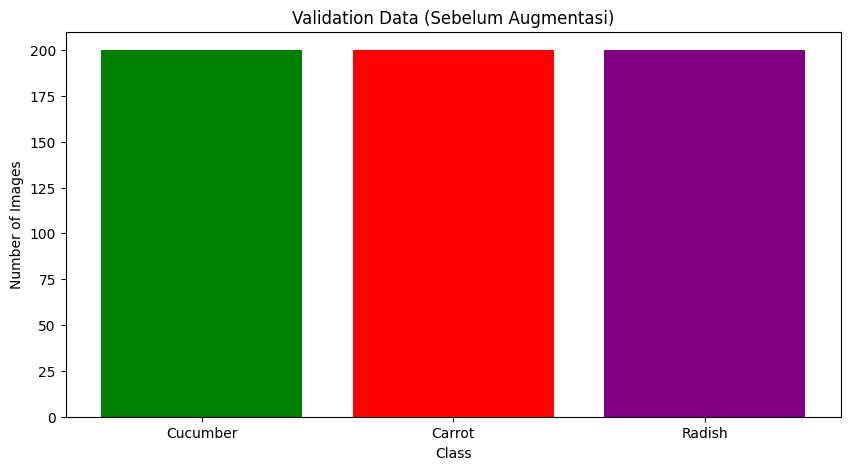


Validation Data (Sebelum Augmentasi) Image Counts per Class:
Cucumber: 200 images
Carrot: 200 images
Radish: 200 images


In [4]:
# Daftar kelas yang digunakan
classes = ['Cucumber', 'Carrot', 'Radish']

# Direktori dataset
train_dir = '/content/Vegetable Images/train'
val_dir = '/content/Vegetable Images/validation'

# Fungsi untuk menghitung dan menampilkan distribusi data
def plot_class_distribution(data_dir, title):
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    # Buat plot bar
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color=['green', 'red', 'purple'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

    # Print jumlah gambar di setiap kelas
    print(f"\n{title} Image Counts per Class:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

# Menampilkan distribusi data sebelum augmentasi
print(" Sebaran Data Sebelum Augmentasi:")
plot_class_distribution(train_dir, 'Training Data (Sebelum Augmentasi)')
plot_class_distribution(val_dir, 'Validation Data (Sebelum Augmentasi)')

### Data Preprocessing

In [5]:
# Target total dataset
target_total_size = 10000
target_train_ratio = 0.8
target_val_ratio = 0.2

# Hitung jumlah gambar yang diinginkan
target_train_size = int(target_total_size * target_train_ratio)  # 8000 gambar
target_val_size = target_total_size - target_train_size  # 2000 gambar

# Batch size
batch_size = 32

# ImageDataGenerator untuk training (dengan augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator untuk validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    classes=classes,
    shuffle=True,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    classes=classes,
    shuffle=False,
    class_mode='categorical'
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/Vegetable Images/test',
    target_size=(224, 224),
    batch_size=16,
    classes=classes,
    shuffle=False
)

# Menampilkan jumlah data setelah augmentasi
print(f"\n Final Dataset Size:")
print(f"Total Training Images: {target_train_size}")
print(f"Total Validation Images: {target_val_size}")

Found 3000 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.

 Final Dataset Size:
Total Training Images: 8000
Total Validation Images: 2000


## Modelling

In [6]:
# Membuat model CNN
model = Sequential()

# Layer Convolutional 1
model.add(Conv2D(16, (3, 3), input_shape=(224, 224, 3), padding='same', kernel_regularizer=l2(0.00001), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Layer Convolutional 2
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.00001), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(64, kernel_regularizer=l2(0.00001), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(len(classes), activation='softmax'))

# Callback untuk menghentikan pelatihan lebih awal jika val_accuracy >= 95%
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Tampilkan summary model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,428,323 (24.52 MB)

 Trainable params: 6,428,099 (24.52 MB)

 Non-trainable params: 224 (896.00 B)

In [7]:
# Melatih model
train_models = model.fit(
    train_generator,
    batch_size=32,
    epochs=40,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.6420 - loss: 0.9818 - val_accuracy: 0.3533 - val_loss: 0.9894
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.8157 - loss: 0.5152 - val_accuracy: 0.6950 - val_loss: 0.7718
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.8351 - loss: 0.4445 - val_accuracy: 0.8517 - val_loss: 0.4530
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.8647 - loss: 0.3527 - val_accuracy: 0.8983 - val_loss: 0.3354
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.8681 - loss: 0.3469 - val_accuracy: 0.9300 - val_loss: 0.2643
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.8747 - loss: 0.3120 - val_accuracy: 0.9083 - val_loss: 0.2706
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.8986 - loss: 0.2819 - val_accuracy: 0.9383 - val_loss: 0.1779
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.9137 - loss: 0.2503 - val_accuracy: 0.9500 - v

## Evaluasi dan Visualisasi

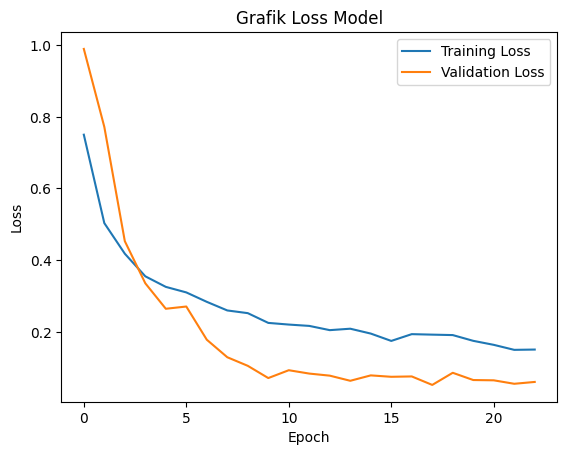

In [17]:
# Mengambil history training
history = train_models.history

# Plot Loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Grafik Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

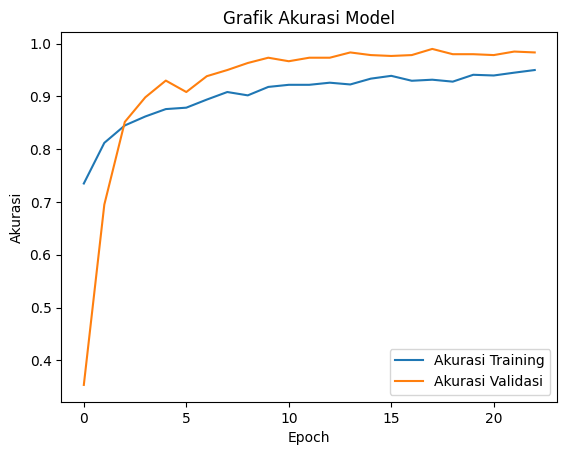

In [15]:
# Mengambil history training
history = train_models.history

# Plot Akurasi
plt.plot(history['accuracy'], label='Akurasi Training')
plt.plot(history['val_accuracy'], label='Akurasi Validasi')
plt.title('Grafik Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [14]:
from sklearn.metrics import classification_report
import pandas as pd

# Predict on the test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Generate classification report as a dictionary
report_dict = classification_report(true_classes, predicted_classes, target_names=classes, output_dict=True)

# Convert the report dictionary to a Pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Display the DataFrame
report_df

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step


,precision,recall,f1-score,support
Cucumber,1.000000,0.995000,0.997494,200.000000
Carrot,0.995025,1.000000,0.997506,200.000000
Radish,0.995000,0.995000,0.995000,200.000000
accuracy,0.996667,0.996667,0.996667,0.996667
macro avg,0.996675,0.996667,0.996667,600.000000
weighted avg,0.996675,0.996667,0.996667,600.000000


In [19]:
accuracy = history['accuracy'][-1]
val_accuracy = history['val_accuracy'][-1]

# Rounding up the values
rounded_accuracy = math.ceil(accuracy * 100)
rounded_val_accuracy = math.ceil(val_accuracy * 100)

print(f"Akurasi: {rounded_accuracy}%")
print(f"Validasi Akurasi: {rounded_val_accuracy}%")

Akurasi: 95%
Validasi Akurasi: 99%


## Konversi Model

In [21]:
# Save Model as H5
H5_MODEL_DIR = 'model_h5'
os.makedirs(H5_MODEL_DIR, exist_ok=True)
h5_model_file = os.path.join(H5_MODEL_DIR, 'model.h5')
model.save(h5_model_file)

print(f"H5 model saved at: {h5_model_file}")

H5 model saved at: model_h5/model.h5


In [24]:
# Save Model as SavedModel
MODEL_DIR = 'model_savedmodel'
version = 1

export_path = os.path.join(MODEL_DIR, str(version))
tf.saved_model.save(model, export_path)

print(f"Model Saved at: {export_path}")

Model Saved at: model_savedmodel/1


In [27]:
# Lokasi model SavedModel yang akan dikonversi
MODEL_DIR = 'model_savedmodel'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))

# Nama file TFLite yang dihasilkan
TFLITE_MODEL_PATH = 'model.tflite'

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {TFLITE_MODEL_PATH}")

TFLite model saved at: model.tflite


In [32]:
# Daftar kelas/label
classes = ['Cucumber', 'Carrot', 'Radish']

# Nama file label
LABEL_FILE = "labels.txt"

# Tulis label ke file
with open(LABEL_FILE, 'w') as f:
    for label in classes:
        f.write(label + '\n')

print(f"File label telah dibuat: {LABEL_FILE}")

File label telah dibuat: labels.txt


In [15]:
import tensorflowjs as tfjs

# Save Model As TFJS
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [31]:
model_dirs = {
    'model_h5': '/content/model_h5',
    'model_savedmodel': '/content/model_savedmodel'
}

def zip_dir(dir_path, zip_path):
    """Zip a directory and its subdirectories."""
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, dir_path)
                zipf.write(file_path, arcname=arcname)

for dir_name, dir_path in model_dirs.items():
  output_zip_path = f'/content/{dir_name}.zip'
  # Panggil fungsi zip directory
  zip_dir(dir_path, output_zip_path)

  # Download zip file
  files.download(output_zip_path)
  print(f"Model directory {dir_name} zipped and downloaded to: {output_zip_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model directory model_h5 zipped and downloaded to: /content/model_h5.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model directory model_savedmodel zipped and downloaded to: /content/model_savedmodel.zip


In [16]:
def zip_dir(dir_path, zip_path):
    """Zip a directory and its subdirectories."""
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, dir_path)
                zipf.write(file_path, arcname=arcname)

# Path to the directory you want to zip
dir_path = '/content/tfjs_model'

# Name of the output zip file
output_zip_path = '/content/model_tfjs.zip'

# Call the function to zip the directory
zip_dir(dir_path, output_zip_path)

# Download the zip file to your local machine
files.download(output_zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

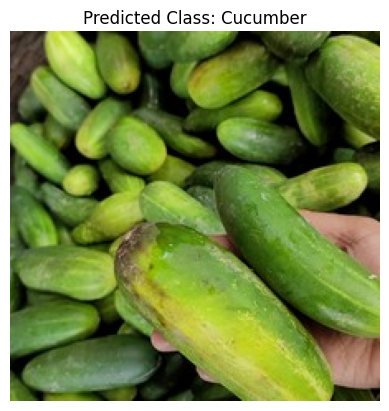

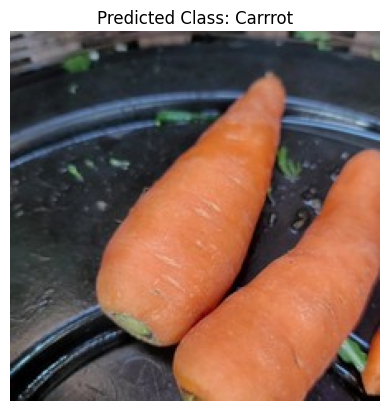

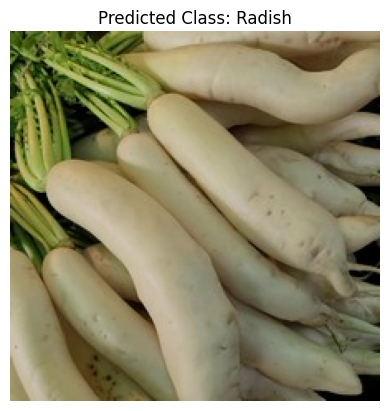

Predicted class: ('Cucumber', 'Carrrot', 'Radish')


In [30]:
# Load the SavedModel from local path
MODEL_DIR = 'model_savedmodel'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
model = tf.saved_model.load(export_path)

# Define the prediction function based on the loaded model
def predict(img_path):
    # Load and preprocess the test image
    img = image.load_img(img_path, target_size=(224, 224))  # Adjusted target size to 224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Perform inference
    infer = model.signatures["serving_default"]
    prediction = infer(tf.constant(img_array))  # Menggunakan tensor untuk prediksi

    # Access the prediction values using the correct output tensor name
    # Replace 'dense' with the actual output tensor name if it's different
    prediction_values = prediction['output_0'].numpy()

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction_values)

    # Class labels
    class_names = ['Cucumber', 'Carrrot', 'Radish']  # Updated class names
    predicted_class_name = class_names[predicted_class_index]

    # Show image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.axis('off')
    plt.show()

    return predicted_class_name

# Path to the image to be tested
image_path_1 = "/content/Vegetable Images/test/Cucumber/1026.jpg"
image_path_2 = "/content/Vegetable Images/test/Carrot/1039.jpg"
image_path_3 = "/content/Vegetable Images/test/Radish/1060.jpg"
# Get result
predicted_class_1 = predict(image_path_1)
predicted_class_2 = predict(image_path_2)
predicted_class_3 = predict(image_path_3)
print(f"Predicted class: {predicted_class_1, predicted_class_2, predicted_class_3}")